### c) Load the segmentation image, and the corresponding CT image with PyDicom. Rearrange the image and segmentation ‘pixel array’ given by PyDicom based on the headers. Some relevant headers include:
* ‘Acquisition Number’.
* ‘Slice Index’.
* ‘Per-frame Functional Groups Sequence’ --> ‘Image Position Patient’.
* ‘Segment Identification Sequence’ --> ‘Referenced Segment Number’.

## Carga y visualización de las imágenes DICOM

#### Cargar Archivos DICOM
Cargo los archivos DICOM desde el directorio especificado. Trabajo inicialmente con un subconjunto de los archivos para testear.

**¿Con que CT trabajo? No me ha quedado claro qué subconjunto de archivos usar!**



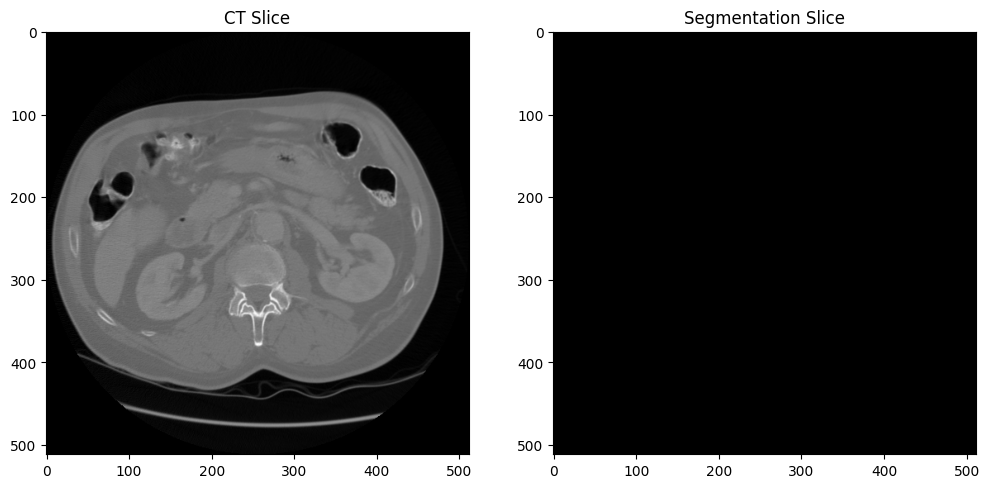

In [119]:
import pydicom
import os
import numpy as np
import matplotlib.pyplot as plt

# Function to load a series of DICOM files
def load_dicom_series(directory):
    files = [pydicom.dcmread(os.path.join(directory, f)) for f in os.listdir(directory) if f.endswith('.dcm')]
    files.sort(key=lambda x: int(x.InstanceNumber)) 
    return np.stack([file.pixel_array for file in files])

ct_directory = "C:/Users/Pedro/Documents/GitHub/Medial_Image_Pydicom/HCC_007/manifest-1643035385102/HCC-TACE-Seg/HCC_007/03-14-1998-NA-CT ABDOMEN WWO CONT-48924/4.000000-Recon 2 3 PHASE LIVER ABD-87008"
#ct_directory_2 = "C:/Users/Pedro/Documents/GitHub/Medial_Image_Pydicom/HCC_007/manifest-1643035385102/HCC-TACE-Seg/HCC_007/03-14-1998-NA-CT ABDOMEN WWO CONT-48924/2.000000-PRE LIVER-48636"
ct_images = load_dicom_series(ct_directory)

# Load Segmentation image
seg_file = "C:/Users/Pedro/Documents/GitHub/Medial_Image_Pydicom/HCC_007/manifest-1643035385102/HCC-TACE-Seg/HCC_007/12-27-1997-NA-AP LIVER PRT WWO-67834/300.000000-Segmentation-39839/1-1.dcm"
seg_image = pydicom.dcmread(seg_file).pixel_array

# the segmentation is multi-slice and I proceed to visualize the middle one just for test the visdualisation
mid_slice_index = seg_image.shape[0] // 2
seg_slice = seg_image[mid_slice_index, :, :]

# Visualizing one slice of CT and corresponding segmentation slice
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(ct_images[mid_slice_index], cmap='gray')  # Same slice index for CT
plt.title('CT Slice')
plt.subplot(1, 2, 2)
plt.imshow(seg_slice, cmap='gray')  # Display the middle slice of segmentation
plt.title('Segmentation Slice')
plt.show()

#### Estudio de encabezados

#### Organización de las imágenes DICOM

Aqui uso el encabezado Image Position (Patient) para ordenar las imágenes.

In [120]:
# Rutas de las imágenes
segmented_image_path = 'C:/Users/Pedro/Documents/GitHub/Medial_Image_Pydicom/HCC_007/manifest-1643035385102/HCC-TACE-Seg//HCC_007/12-27-1997-NA-AP LIVER PRT WWO-67834/300.000000-Segmentation-39839/1-1.dcm'
#ct_image_path = '/Users/pedromarti/Desktop/Master/AIM/Practica/HCC_007/03-14-1998-NA-CT ABDOMEN WWO CONT-48924/4.000000-Recon 2 3 PHASE LIVER ABD-87008/1-001.dcm'
ct_images_dir = 'C:/Users/Pedro/Documents/GitHub/Medial_Image_Pydicom/HCC_007/manifest-1643035385102/HCC-TACE-Seg/HCC_007/03-14-1998-NA-CT ABDOMEN WWO CONT-48924/2.000000-PRE LIVER-48636'

# Cargar las imágenes
segmentation_image = pydicom.dcmread(segmented_image_path) # Cargar imagen de segmentación

# Cargar imágenes de CT
ct_files = [f for f in os.listdir(ct_images_dir) if f.endswith('.dcm')]
ct_images = [pydicom.dcmread(os.path.join(ct_images_dir, f)) for f in ct_files]

# Verificar la uniformidad de 'Acquisition Number'
acquisition_numbers = set(img.AcquisitionNumber for img in ct_images)
if len(acquisition_numbers) > 1:
    raise ValueError("Multiple acquisition numbers found. Ensure all CT images are from a single acquisition.")

# Organización de imágenes CT según 'Image Position Patient'
ct_images.sort(key=lambda x: float(x.ImagePositionPatient[2]))

# Mostrar detalles relevantes
print("Details of CT images sorted by Image Position Patient:")
for img in ct_images:
    print(f"Acquisition Number: {img.AcquisitionNumber}, Image Position Patient: {img.ImagePositionPatient}")

# Preparación de arrays de píxeles
segmentation_array = segmentation_image.pixel_array
ct_arrays = np.stack([img.pixel_array for img in ct_images])

print("Dimensiones del arreglo de segmentación:", segmentation_array.shape)
print("Dimensiones del arreglo de imágenes CT:", ct_arrays.shape)

Details of CT images sorted by Image Position Patient:
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -254.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -244.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -234.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -224.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -214.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -204.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -194.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -184.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -174.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -164.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -

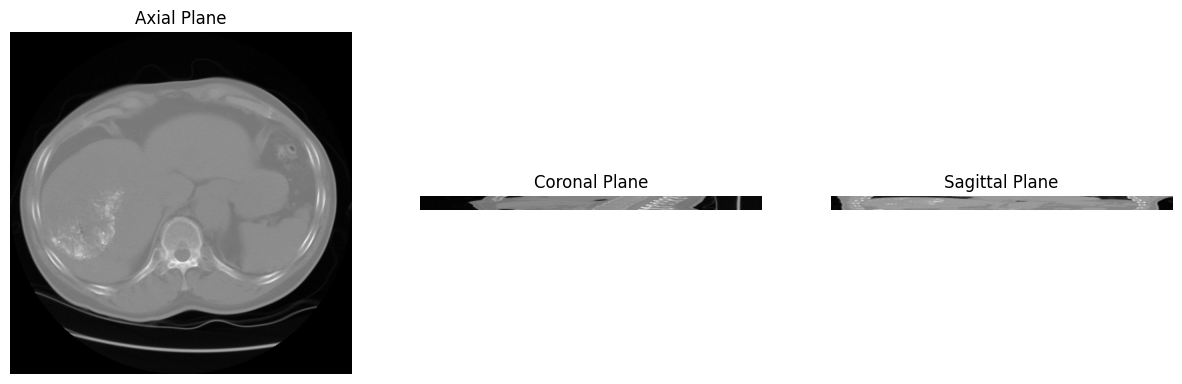

In [121]:
def visualize_planes(ct_volume):
    # Extraer los planos coronal y sagital
    coronal_plane = ct_volume[:, :, ct_volume.shape[2]//2]  # slice en el medio del eje X
    sagittal_plane = ct_volume[:, ct_volume.shape[1]//2, :]  # slice en el medio del eje Y
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(ct_volume[ct_volume.shape[0]//2], cmap='gray')  # Plano axial
    axes[0].set_title('Axial Plane')
    axes[1].imshow(coronal_plane, cmap='gray', origin='lower')
    axes[1].set_title('Coronal Plane')
    axes[2].imshow(sagittal_plane, cmap='gray', origin='lower')
    axes[2].set_title('Sagittal Plane')
    
    for ax in axes:
        ax.axis('off')
    plt.show()

# Visualizar los planos
visualize_planes(ct_arrays)

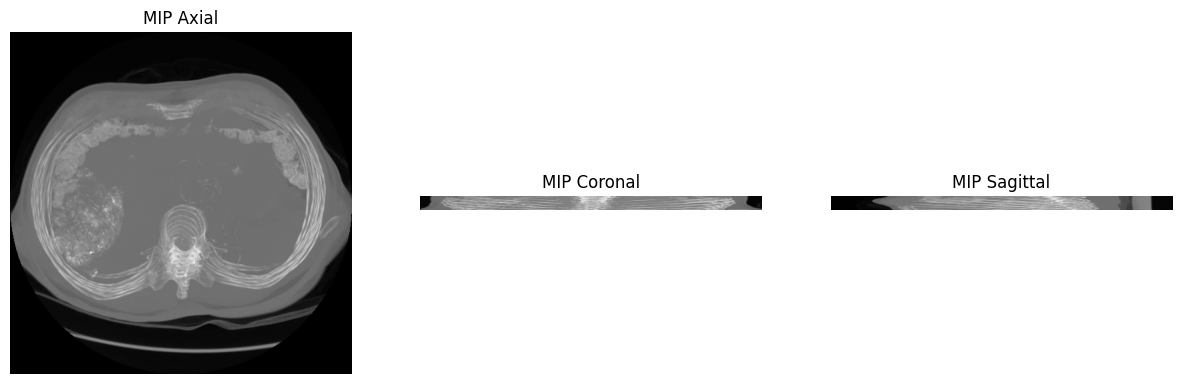

In [122]:
def create_mip(ct_volume):
    mip_axial = np.max(ct_volume, axis=0)
    mip_coronal = np.max(ct_volume, axis=1)
    mip_sagittal = np.max(ct_volume, axis=2)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(mip_axial, cmap='gray')
    axes[0].set_title('MIP Axial')
    axes[1].imshow(mip_coronal, cmap='gray')
    axes[1].set_title('MIP Coronal')
    axes[2].imshow(mip_sagittal, cmap='gray')
    axes[2].set_title('MIP Sagittal')
    
    for ax in axes:
        ax.axis('off')
    plt.show()

# Generar y visualizar MIP
create_mip(ct_arrays)


## Visualización

#### Pregunta: ¿Hem d'aplicar una transformació d'intensitat per a que l'image es visualitzi millor (Windowing)? T2 pg 28-33

Visualización de correspondencias

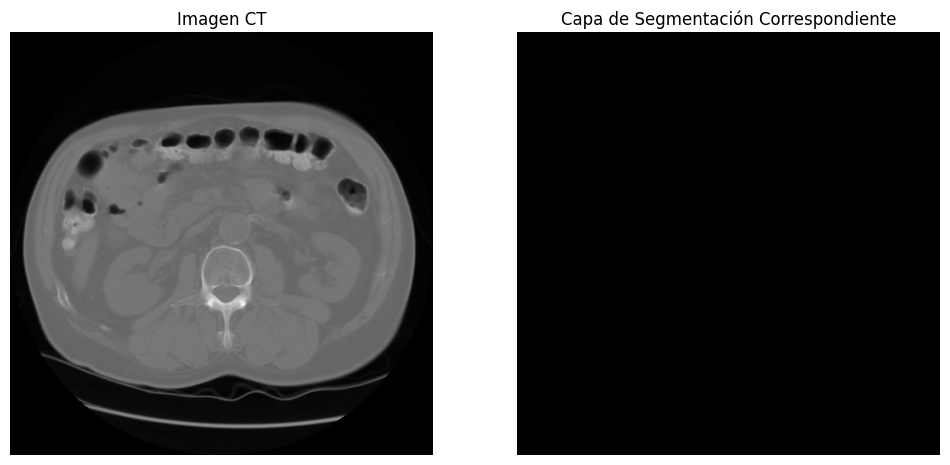

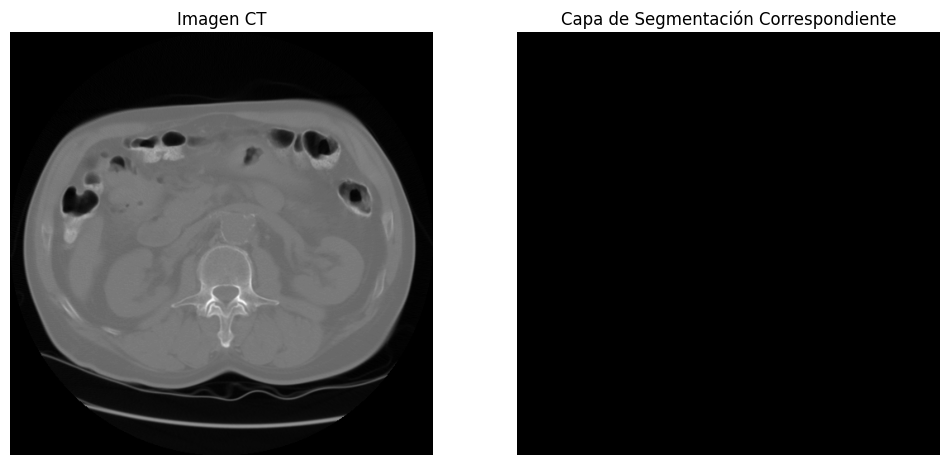

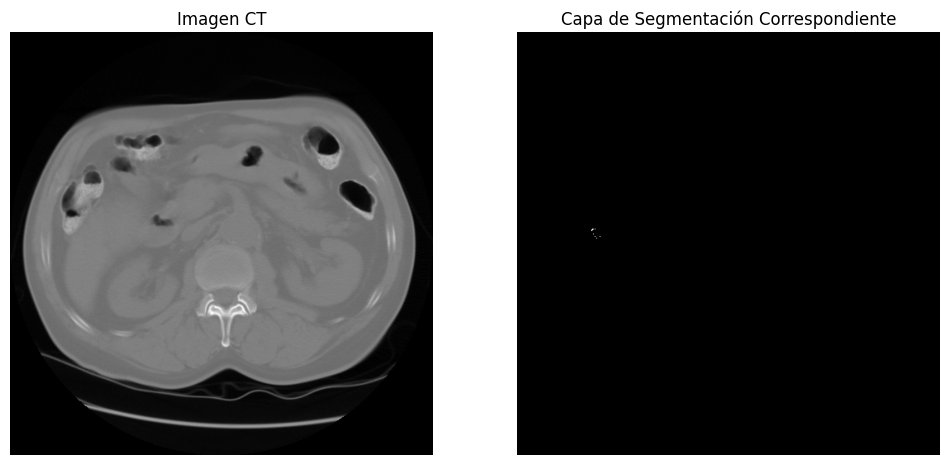

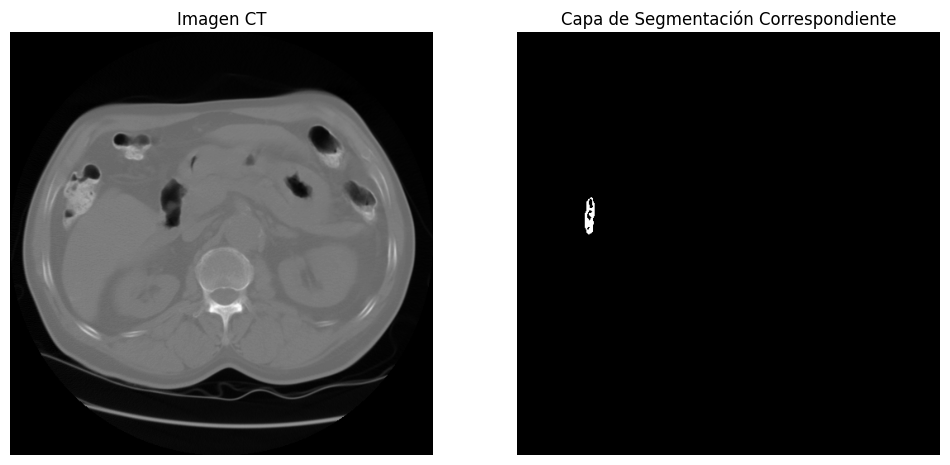

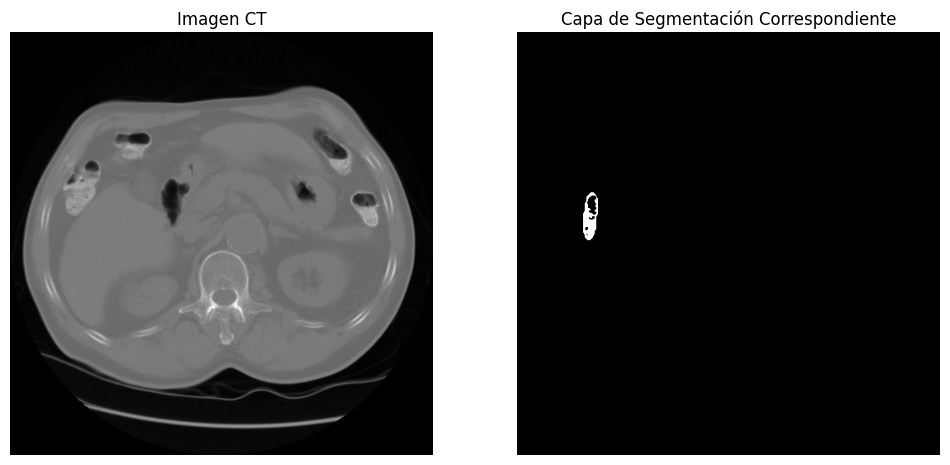

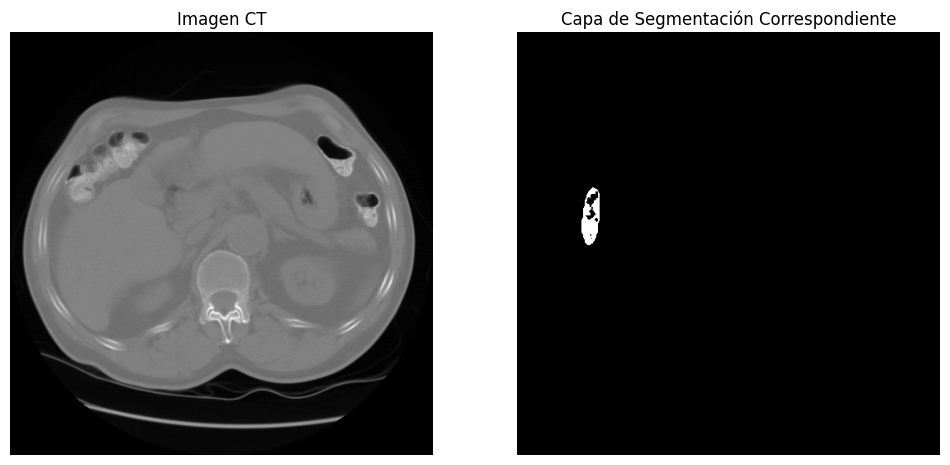

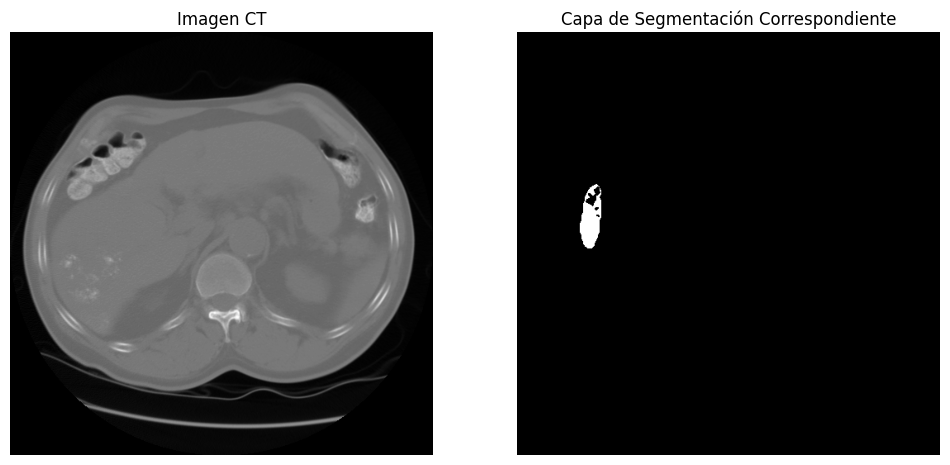

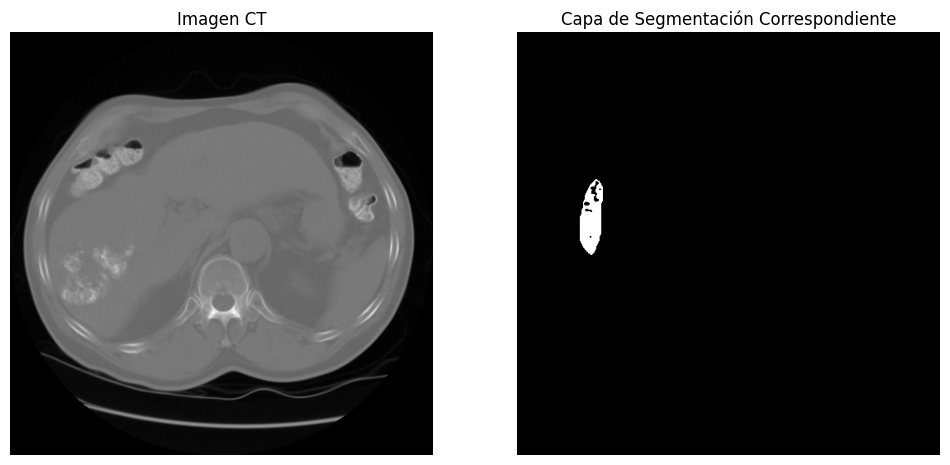

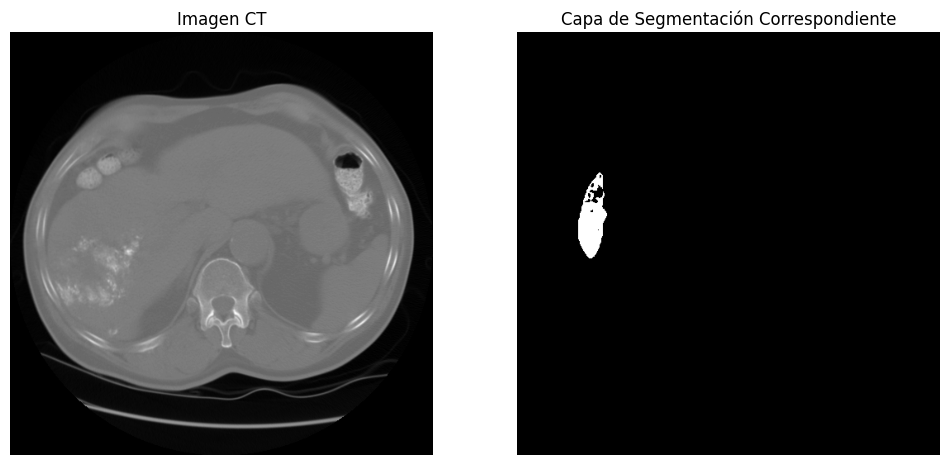

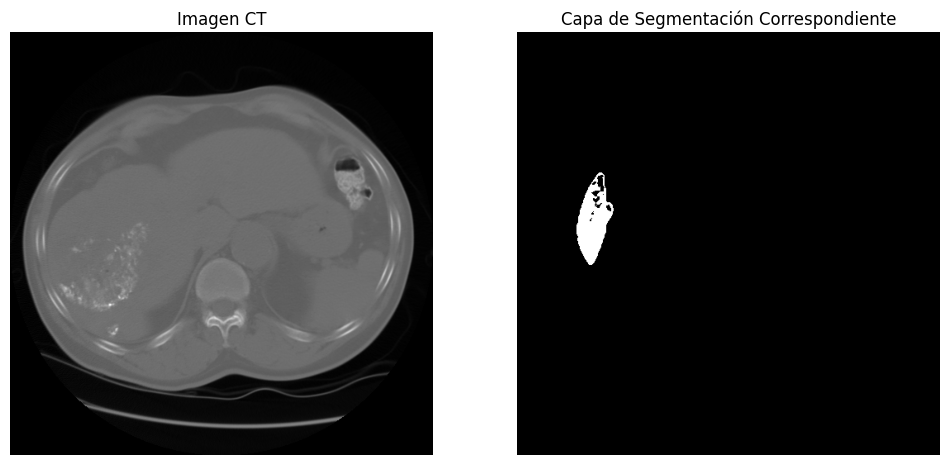

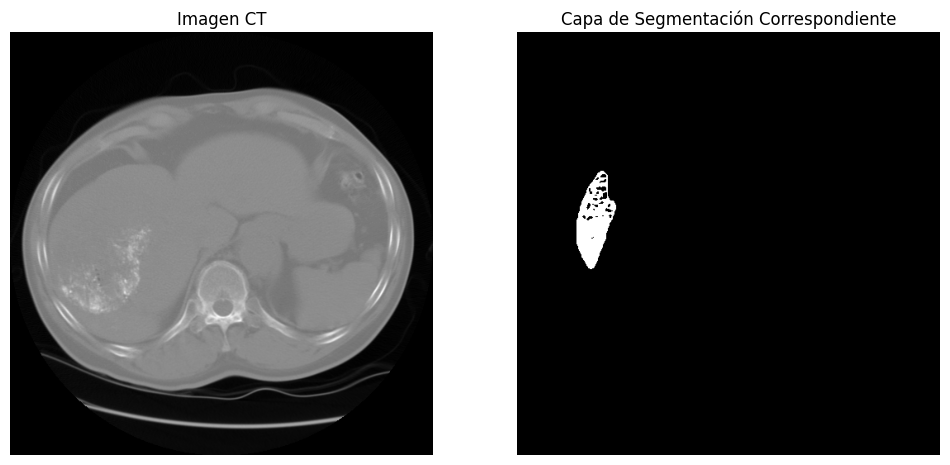

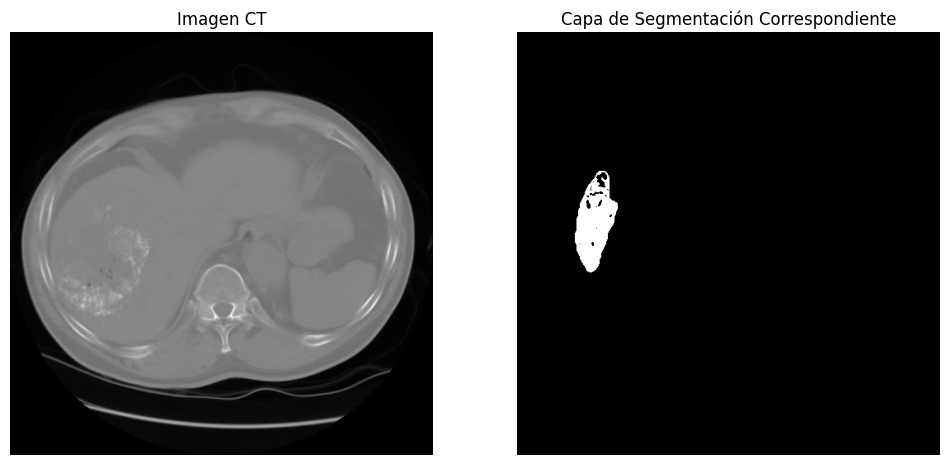

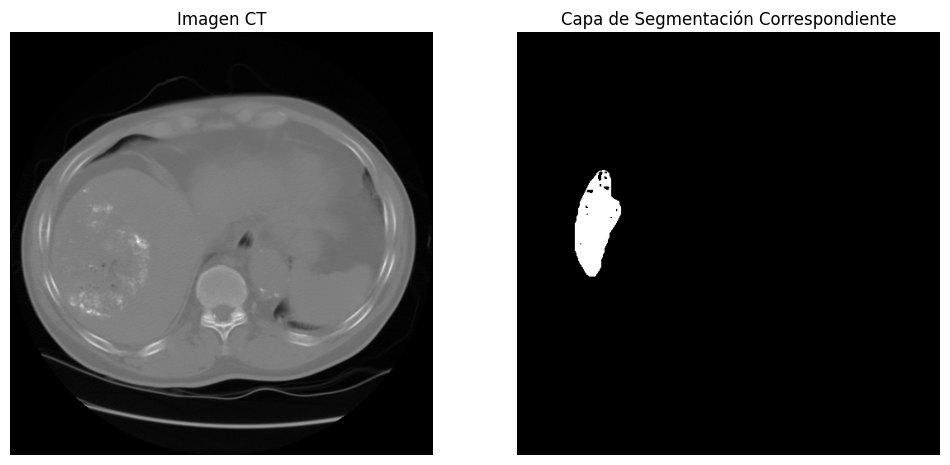

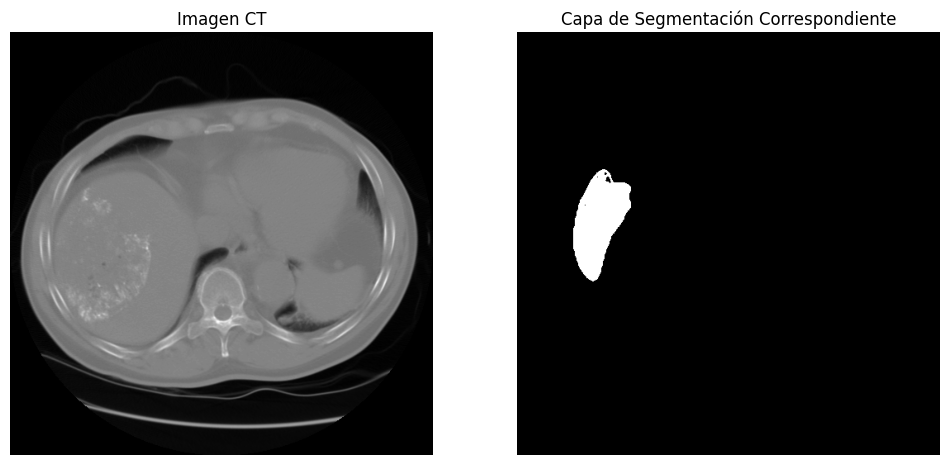

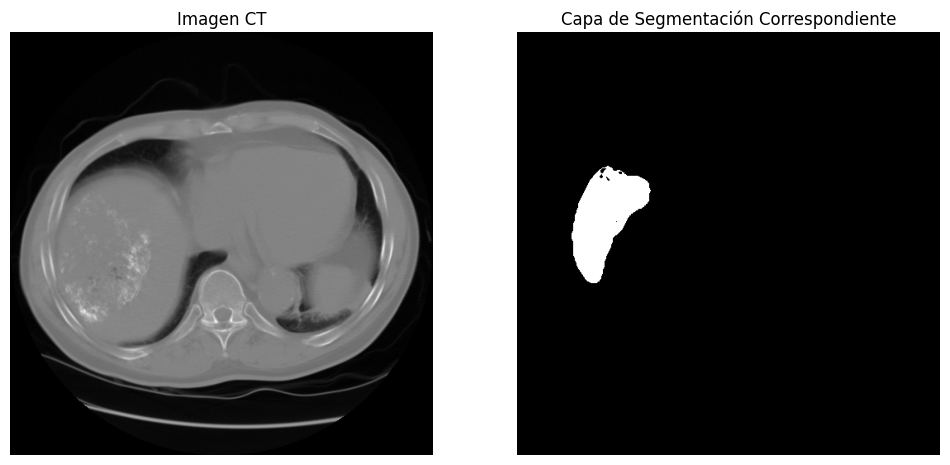

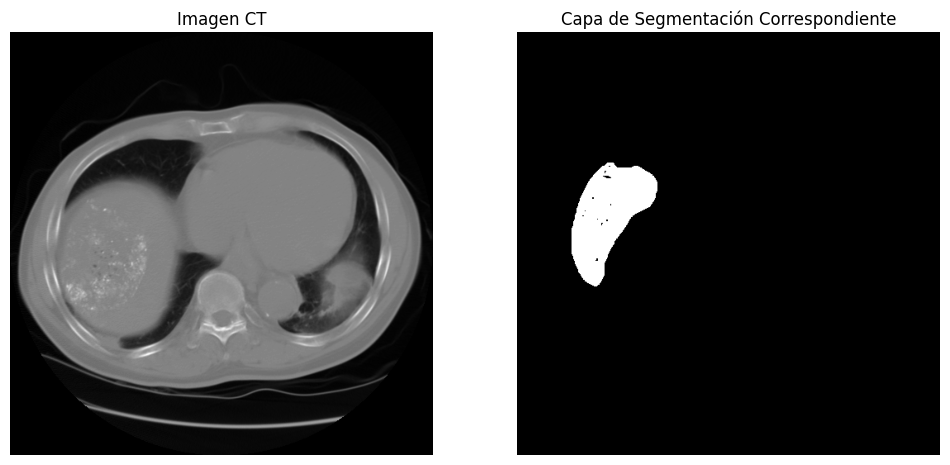

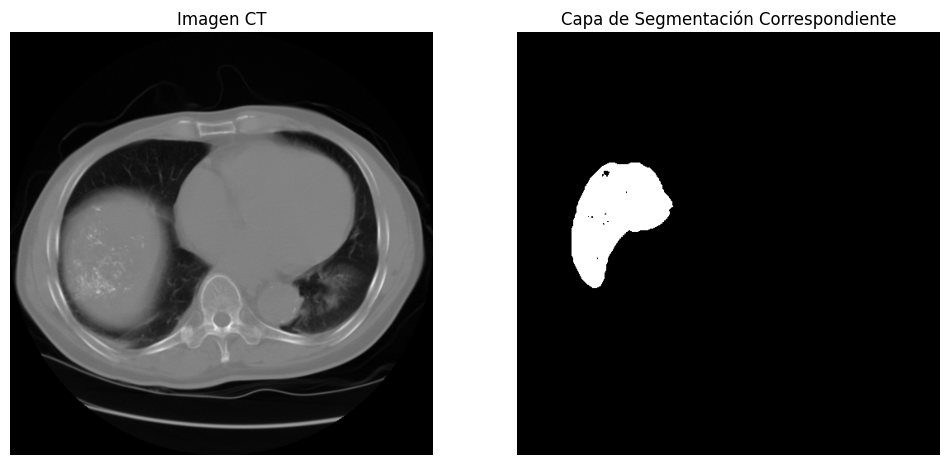

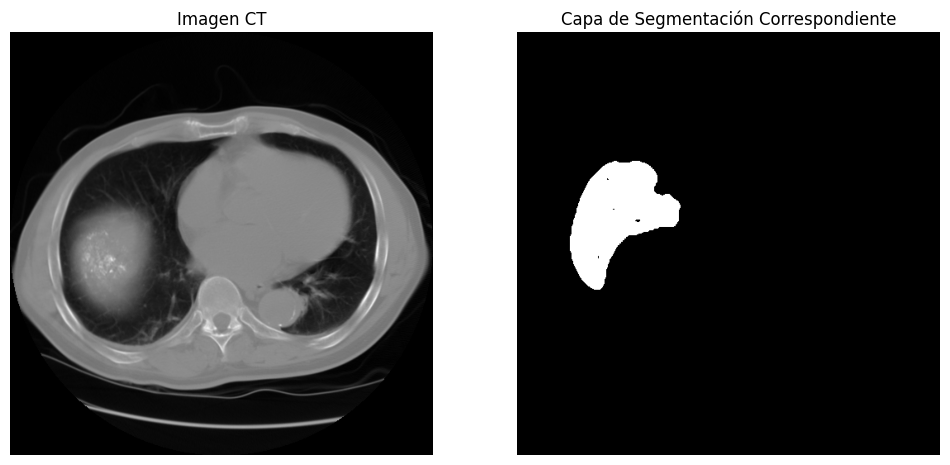

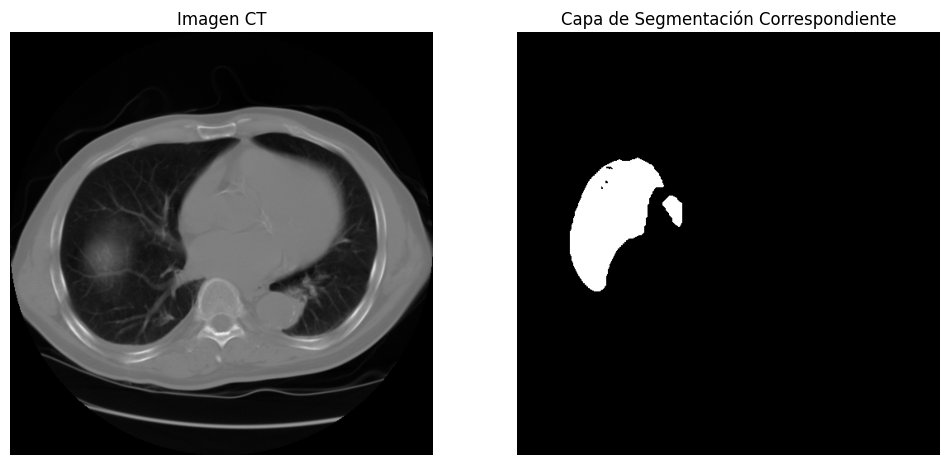

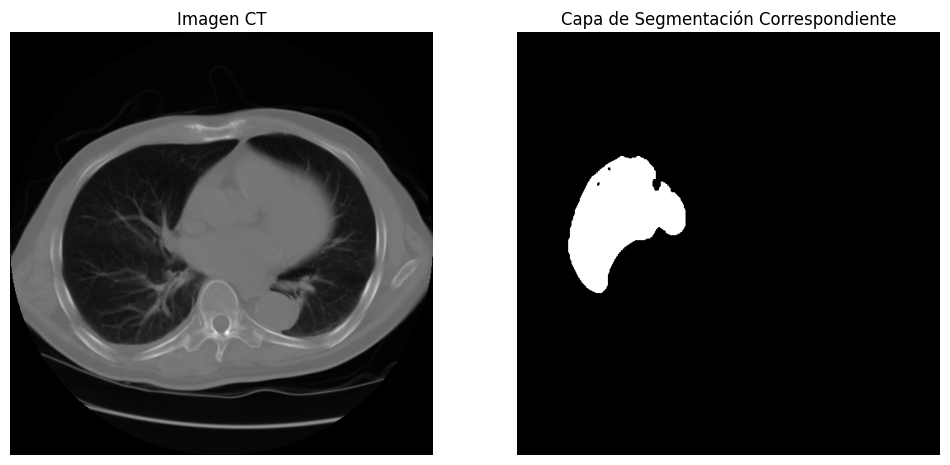

In [123]:
# Función para visualizar imágenes CT y de segmentación
def plot_images(ct_image, segmentation_layer):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(ct_image, cmap='gray')
    ax[0].set_title('Imagen CT')
    ax[0].axis('off')

    ax[1].imshow(segmentation_layer, cmap='gray')
    ax[1].set_title('Capa de Segmentación Correspondiente')
    ax[1].axis('off')

    plt.show()

# Suponiendo que cada capa de segmentación corresponde directamente a cada imagen CT
for i in range(len(ct_arrays)):
    plot_images(ct_arrays[i], segmentation_array[i])


In [ ]:
import pydicom
import os
import numpy as np
import matplotlib.pyplot as plt

# Function to apply windowing: C = (I - WL + 0.5 * WW) / WW
def apply_window(image, window_center, window_width):
    lower_bound = window_center - 0.5 * window_width
    upper_bound = window_center + 0.5 * window_width
    return np.clip((image - lower_bound) / window_width, 0, 1)

# Function to load and apply windowing to a series of DICOM files
def load_dicom_series_with_windowing(directory, window_center, window_width):
    files = [pydicom.dcmread(os.path.join(directory, f)) for f in os.listdir(directory) if f.endswith('.dcm')]
    files.sort(key=lambda x: int(x.InstanceNumber))
    images = np.stack([file.pixel_array for file in files])
    return np.stack([apply_window(img, window_center, window_width) for img in images])

# Load and visualize CT images with windowing
window_center, window_width = 40, 400
ct_images = load_dicom_series_with_windowing(ct_directory, window_center, window_width)

# Visualization function including colormap for segmentation
def plot_images_with_colormap(ct_image, segmentation_layer):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(ct_image, cmap='gray') #Colormap
    ax[0].set_title('CT Slice with Windowing')
    ax[0].axis('off')

    ax[1].imshow(segmentation_layer, cmap='prism')  #colormap
    ax[1].set_title('Segmentation Slice')
    ax[1].axis('off')

    plt.show()

# Demonstrate the visualization for all slices
for i in range(len(ct_images)):
    plot_images_with_colormap(ct_images[i], seg_image[i])


#### Intentando hacer el ROI con las cuatro regiones

In [134]:
import pydicom

def check_slice_order(ct_directory):
    ct_files = sorted(os.listdir(ct_directory), key=lambda x: int(pydicom.dcmread(os.path.join(ct_directory, x)).InstanceNumber))
    positions = [pydicom.dcmread(os.path.join(ct_directory, f)).ImagePositionPatient[2] for f in ct_files]
    print("Positions of CT slices:", positions)

# Llamada a la función para verificar el orden de las slices
check_slice_order(ct_directory)


Positions of CT slices: ['-65.0', '-67.5', '-70.0', '-72.5', '-75.0', '-77.5', '-80.0', '-82.5', '-85.0', '-87.5', '-90.0', '-92.5', '-95.0', '-97.5', '-100.0', '-102.5', '-105.0', '-107.5', '-110.0', '-112.5', '-115.0', '-117.5', '-120.0', '-122.5', '-125.0', '-127.5', '-130.0', '-132.5', '-135.0', '-137.5', '-140.0', '-142.5', '-145.0', '-147.5', '-150.0', '-152.5', '-155.0', '-157.5', '-160.0', '-162.5', '-165.0', '-167.5', '-170.0', '-172.5', '-175.0', '-177.5', '-180.0', '-182.5', '-185.0', '-187.5', '-190.0', '-192.5', '-195.0', '-197.5', '-200.0', '-202.5', '-205.0', '-207.5', '-210.0', '-212.5', '-215.0', '-217.5', '-220.0', '-222.5', '-225.0', '-227.5', '-230.0', '-232.5', '-235.0', '-237.5', '-240.0', '-242.5', '-245.0', '-247.5', '-250.0', '-252.5', '-255.0', '-257.5', '-260.0', '-65.0', '-67.5', '-70.0', '-72.5', '-75.0', '-77.5', '-80.0', '-82.5', '-85.0', '-87.5', '-90.0', '-92.5', '-95.0', '-97.5', '-100.0', '-102.5', '-105.0', '-107.5', '-110.0', '-112.5', '-115.0', '-1

In [142]:
import pydicom
import numpy as np
import os

def verify_alignment(ct_directory, seg_directory):
    ct_files = sorted(os.listdir(ct_directory), key=lambda x: float(pydicom.dcmread(os.path.join(ct_directory, x)).SliceLocation))
    seg_files = sorted(os.listdir(seg_directory), key=lambda x: float(pydicom.dcmread(os.path.join(seg_directory, x)).SliceLocation))

    # Comprobar que las longitudes y las ubicaciones de slice coinciden
    if len(ct_files) != len(seg_files):
        print("Error: Different number of slices")
        return False

    for ct, seg in zip(ct_files, seg_files):
        ct_dcm = pydicom.dcmread(os.path.join(ct_directory, ct))
        seg_dcm = pydicom.dcmread(os.path.join(seg_directory, seg))
        
        if ct_dcm.SliceLocation != seg_dcm.SliceLocation:
            print(f"Mismatch at slice {ct}: CT {ct_dcm.SliceLocation} vs. Seg {seg_dcm.SliceLocation}")
            return False

    print("All slices are aligned correctly.")
    return True

verify_alignment(ct_directory, seg_file)


FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: 'path_to_your_ct_images'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

def visualize_ct_with_segmentation(ct_slice, seg_slice):
    
    # Crear figura y ejes
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(ct_slice, cmap='gray')  # Visualizar la imagen de CT en escala de grises
    
    # Configuración del colormap para la segmentación con transparencia
    cmap = plt.cm.viridis
    colors = cmap(np.linspace(0, 1, 256))
    colors[:, -1] = np.linspace(0, 0.3, 256)  # Configuración de la transparencia
    colored_cmap = matplotlib.colors.ListedColormap(colors)

    # Superponer la segmentación en la imagen de CT
    seg_im = ax.imshow(seg_slice, cmap=colored_cmap, interpolation='none')
    
    ax.set_title('CT Slice with Segmentation Overlay')
    plt.axis('off')
    plt.show()

# Iterar sobre cada slice en el conjunto de datos de CT y Segmentación
for i in range(len(ct_images)):
    ct_slice = ct_images[i]
    seg_slice = segmentation_array[i]
    visualize_ct_with_segmentation(ct_slice, seg_slice)



## MIP

In [47]:
def calculate_mip(ct_volume, axis):
    """ Calculate the Maximum Intensity Projection (MIP) along a given axis. """
    return np.max(ct_volume, axis=axis)  # axis=1 collapses the Y-axis


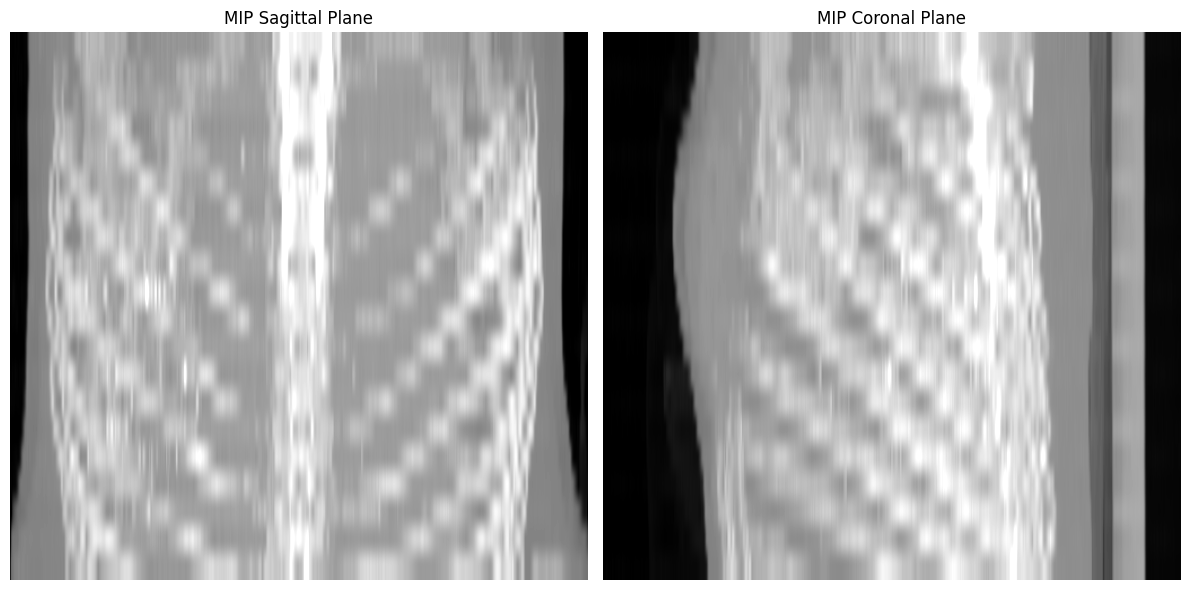

In [100]:
import scipy.ndimage

# Calcule MIPs for sagittal and coronal planes
mip_sagittal = calculate_mip(ct_arrays, axis=1)  # Sagittal: collapsing the Y-axis
mip_coronal = calculate_mip(ct_arrays, axis=2)  # Coronal: collapsing the X-axis

def display_mip_images(mip_sagittal, mip_coronal):
    plt.figure(figsize=(12, 6))

    # Obtén los percentiles para ajustar el rango de visualización
    vmin_s, vmax_s = np.percentile(mip_sagittal, [2, 98])
    vmin_c, vmax_c = np.percentile(mip_coronal, [2, 98])

    plt.subplot(1, 2, 1)
    plt.imshow(mip_sagittal, cmap='gray', aspect='auto', vmin=vmin_s, vmax=vmax_s)
    plt.title('MIP Sagittal Plane')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mip_coronal, cmap='gray', aspect='auto', vmin=vmin_c, vmax=vmax_c)
    plt.title('MIP Coronal Plane')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Llama a la función con tus imágenes MIP
display_mip_images(mip_sagittal, mip_coronal)

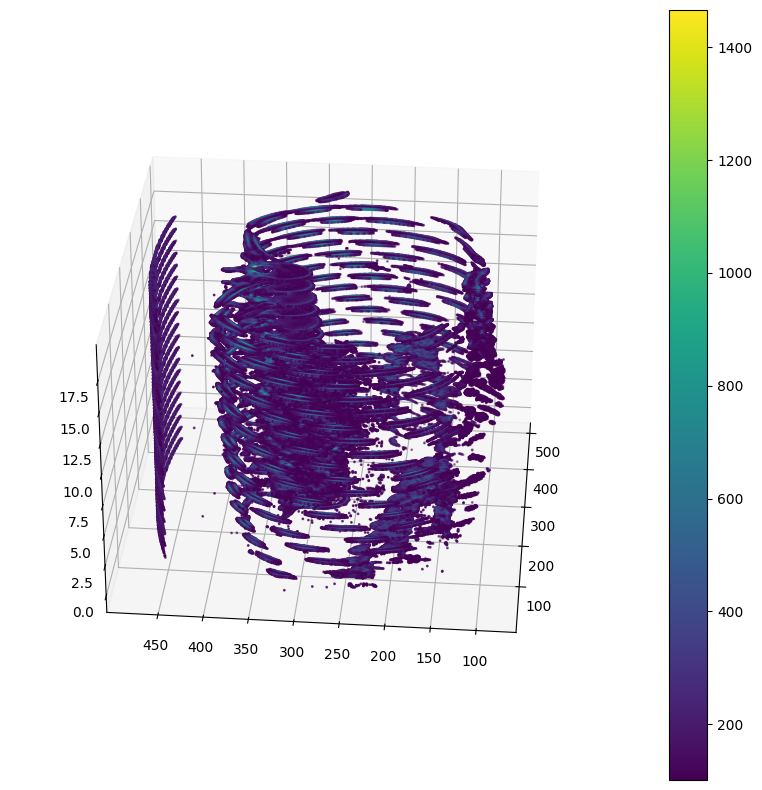

In [101]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

def plot_3d(image, threshold=-300, rotation_angle=360, interval=50):
    # Preparar los datos
    p = image.transpose(2, 1, 0)
    p = p.clip(min=threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    pos = np.where(p > threshold)
    colors = p[pos] # Intensidad de los colores

    scat = ax.scatter(pos[0], pos[1], pos[2], c=colors, cmap='viridis', s=1)
    ax.view_init(30, 185) #Inicializa la vista

    # Función de actualización para la animación
    def update(frame):
        ax.view_init(30, frame)
        return scat,
    
    # Crear la animación
    ani = FuncAnimation(fig, update, frames=np.arange(0, rotation_angle, 2), interval=interval, blit=False)
    plt.colorbar(scat, ax=ax, orientation='vertical')  # Añadir colorbar para interpretación
    plt.show()

    return ani

# Suponemos que ct_arrays es tu arreglo 3D de datos CT
plot_3d(ct_arrays, threshold=100, rotation_angle=360, interval=50)  # Ajusta el umbral según sea necesario


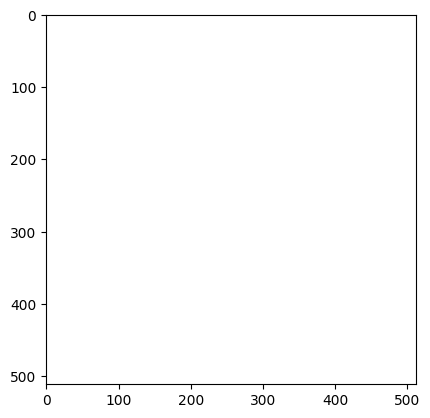

In [88]:
from matplotlib import animation
import scipy.ndimage
from matplotlib.animation import PillowWriter

def plot_3d_projections(img_dcm):
    # Asumimos que img_dcm es el arreglo 3D de imágenes CT
    angles = np.linspace(0, 360, num=36, endpoint=False)  # Rotar de 0 a 360 grados
    projections = []
    
    fig, ax = plt.subplots()
    for angle in angles:
        rotated = scipy.ndimage.rotate(img_dcm, angle, axes=(1, 2), reshape=False)
        mip = calculate_mip(rotated, axis=0)  # Calcular MIP en el plano que sea más relevante, e.g., axial
        projections.append(mip)
    
    ims = [[ax.imshow(proj, cmap='gray', animated=True)] for proj in projections]
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    plt.show()
    ani.save('3D_projections.gif', writer=PillowWriter(fps=20))  # Guardar la animación

# Llamar a la función con el volumen de datos CT
plot_3d_projections(ct_arrays)